In [1]:
import crispat
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
data_dir = '../example_data/'

# Prepare data for guide assignment
To apply one of the 11 guide assignment functions of the crispat package, we first have to create and save an AnnData object containing the gRNA counts for all cells. Depending on the format of your input data, this can either be done by using one of our import functions or for more customizability directly using the `anndata` package. In our package, we provide two functions that either read in cellranger output (`create_anndata_from_cellranger`) or a csv file with the gRNA-cell matrix (`create_anndata_from_csv`) to create the .h5ad file. If creating an AnnData object yourself, make sure to add a `batch` column to adata.obs even if you only have one batch (use same value for all cells in this case). 

## Version 1: create AnnData object from cellranger output 

To use this function, the `input_dir` should contain one folder per batch (called batch1, batch2 etc.) that contain the barcodes.tsv.gz, features.tsv.gz and matrix.mtx.gz files obtained from cellranger count.

## Version 2: create AnnData object from a csv file containing the gRNA count matrix 

The input csv file for the `create_anndata_from_csv` function should look like this: first column contains gRNA names, remaining columns gRNA counts per cell. The function is designed for screens that only contain one experimental batch. 

In [3]:
# check input_csv format
input_csv = pd.read_csv(data_dir + 'Schraivogel/gRNA_counts.csv')
input_csv.iloc[0:5, 0:5]

,gRNA,TAP1-AAACCTGAGCCTATGT,TAP1-AAACCTGAGGCGTACA,TAP1-AAACCTGAGGGCTTGA,TAP1-AAACCTGAGGGTGTTG
0,CROPseq_dCas9_DS_CCNE2_+_95907328.23-P1P2,0,0,0,0
1,CROPseq_dCas9_DS_CCNE2_+_95907382.23-P1P2,0,0,0,0
2,CROPseq_dCas9_DS_CCNE2_+_95907406.23-P1P2,0,0,0,0
3,CROPseq_dCas9_DS_CCNE2_-_95907017.23-P1P2,0,0,0,0
4,CROPseq_dCas9_DS_CPQ_+_97657557.23-P1P2,0,26,0,0


In [4]:
crispat.create_anndata_from_csv(data_dir + 'Schraivogel/gRNA_counts.csv', data_dir + 'Schraivogel/')

Load data
Create anndata object
Done: AnnData object is saved in ../example_data/Schraivogel/


In [5]:
# the resulting anndata object that is used as input for all guide assignment methods looks like this
ad.read_h5ad(data_dir + 'Schraivogel/gRNA_counts.h5ad')

AnnData object with n_obs × n_vars = 21977 × 86
    obs: 'batch'

Short note about the dimensions of the AnnData object: the TAPseq screen from Schraivogel et al. contains 21,977 cells and 86 gRNAs (30 non-targeting and 56 targeting gRNAs for 14 different targets) 

# Run guide assignment
This package contains implementations of 11 different guide assignment methods which we grouped into four main categories based on whether information is shared across gRNAs, cells or both. Details on all functions can be found in our manuscript (link will be added very soon).

## Independent
The simplest approach (called `ga_UMI`) is to not share any information across the gRNA-cell matrix and check for each value separately whether it is at least as high than a fixed threshold (assign cells with gRNA counts >= threshold). To find a suitable threshold, a list of thresholds is passed as one argument of the function (UMI threshold of 4, 5 and 7 in the following example).

In [6]:
# Guide assignment with UMI thresholds
crispat.ga_umi(data_dir + 'Schraivogel/gRNA_counts.h5ad', [4,5,7], 
               data_dir + 'guide_assignments/UMI/')

Guide assignment with UMI threshold
Load gRNA counts
Get perturbed cells for each gRNA with UMI threshold = 4
Get perturbed cells for each gRNA with UMI threshold = 5
Get perturbed cells for each gRNA with UMI threshold = 7
Done: outputs are saved in ../example_data/guide_assignments/UMI/


## Across gRNAs
In the next group of methods, information is shared across gRNAs. The simplest approach of this group is to assign for each cell the gRNA with highest counts in this cell (if there is a unique maximum).

In [7]:
# Maximum guide assignment 
crispat.ga_max(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
               data_dir + 'guide_assignments/maximum/')

Guide assignment with maximum assignment
Load gRNA counts
Done: outputs are saved in ../example_data/guide_assignments/maximum/


Additionally, crispat includes an option to apply a UMI threshold to the initial assignment such that only cells with at least `UMI_threshold` counts are kept in the assignment output. This additional filtering option is available for all assignment methods in crispat apart from `ga_umi` which already uses an UMI threshold. An example usage of this option in the maximum assignment is shown in the next chunk in which assigned cells with less than 3 UMI counts for the assigned gRNA are removed. 

In [8]:
crispat.ga_max(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
               data_dir + 'guide_assignments/maximum/', UMI_threshold = 3)

Guide assignment with maximum assignment
Load gRNA counts
Done: outputs are saved in ../example_data/guide_assignments/maximum/


An adaptation of the maximum approach is to only assign the most abundant gRNA per cell if the counts of this gRNA comprise at least a certain percentage X of the total counts of the cell. The list of percentages X to use as ratio_thresholds is provided as an argument of the function.

In [9]:
# Guide assignment with ratio thresholds
crispat.ga_ratio(data_dir + 'Schraivogel/gRNA_counts.h5ad', [0.3, 0.5, 0.7], 
                 data_dir + 'guide_assignments/ratios/')

Guide assignment with ratio assignment
Load gRNA counts
Done: outputs are saved in ../example_data/guide_assignments/ratios/


## Across cells
The next group of methods is performed across cells by fitting a mixture model for each gRNA. `ga_gauss` is based on the Cell Ranger assignment which fits a Gaussian mixture model to the log10-transformed UMI counts for each batch and gRNA. For this method, two different inference methods can be used: either using variational inference with pyro as in the other mixture models (`inference = "vi"`, default) or using an EM algorithm (`inference = "em"`) based on sklearn as done in the original Cell Ranger implementation. Additionally, there is an option to fit the model on nonzero values only (`nonzero = True`) which can lead to improved performance as shown in our [paper](https://academic.oup.com/bioinformatics/article/40/9/btae535/7750392). 

In [10]:
# Guide assignment with Cell Ranger approach (Gaussian mixture model)
crispat.ga_gauss(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
                 data_dir + 'guide_assignments/gauss/', 
                 inference = 'em')

Guide assignment using a Gaussian mixture model per batch
Load gRNA counts
Fit Gaussian Mixture models for batch 1
Done: outputs are saved in ../example_data/guide_assignments/gauss/


`ga_poisson_gauss` instead uses a Poisson-Gaussian mixture model on the log2-transformed non-zero UMI counts per gRNA similar to the approach by Replogle et al. (Cell, 2022).

In [11]:
# Guide assignment with Poisson-Gaussian mixture model
crispat.ga_poisson_gauss(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
                    data_dir + 'guide_assignments/poisson_gauss/')

Guide assignment with Poisson-Gaussian mixture model as in Replogle et al.
Load gRNA counts
Fit Poisson-Gaussian Mixture Model for each gRNA: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [02:18<00:00,  1.61s/it]

Done: outputs are saved in ../example_data/guide_assignments/poisson_gauss/


## Across gRNAs & cells

The following two methods (`ga_2beta` and `ga_3beta`) also use a threshold on the percentages per cell, but learn a threshold for each batch based on the data distribution. In the `ga_2beta` function, a mixture model consisting of two beta distributions is fitted to the distribution of the percentages of the most abundant gRNAs per cell to distinguish the background/noise counts from the counts of actually perturbed cells. The threshold X is determined as the intersection of the densities of the two mixture components. In the `ga_3beta` function, we use a mixture model with 3 components instead of two such that we can additionally model cells that were infected with two gRNAs. Here, the threshold X is chosen as the intersection of the second and third mixture component (numbering them by increasing mean). 

In [12]:
# Guide assignment with 2-Beta mixture model
crispat.ga_2beta(data_dir + 'Schraivogel/gRNA_counts.h5ad',  
                 data_dir + 'guide_assignments/2-BetaMM/')

Guide assignment fitting a mixture model of two beta distributions
Load gRNA counts
Fit 2-beta mixture model for each batch:
Batch  1
Done: outputs are saved in ../example_data/guide_assignments/2-BetaMM/


In [13]:
# Guide assignment with 3-Beta mixture model
crispat.ga_3beta(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
                 data_dir + 'guide_assignments/3-BetaMM/')

Guide assignment fitting a mixture model of three beta distributions
Load gRNA counts
Fit 3-beta mixture model for each batch:
Batch  1
Done: outputs are saved in ../example_data/guide_assignments/3-BetaMM/


Since `ga_poisson`, `ga_negative_binomial` and `ga_binomial` have the longest run time, these functions automatically are parallelized to run over all available CPUs. If there are fewer gRNAs than available CPUs, the number of parallel processes is reduced to the number of gRNAs specified. If you want to change this default behaviour, you can either set `parallelize` to False to disable the parallelization or manually specify the number of processes (`n_processes`) that should be used (instead of all available). For running these assignment methods on the cluster, we recommend to manually set the `n_processes` parameters depending on your available resources. 

**Caution**: For demonstrating the usage of these functions in this notebook, we are running the guide assignment only on a **data subset** consisting of the first 5 gRNAs. This is achieved by using the `start_gRNA` parameter (index of the first gRNA) and the `gRNA_step` parameter which defines the number of gRNAs for which the assignment is performed. If you want to do guide assignment for all gRNAs, you don't have to specify `start_gRNA` and `gRNA_step`. However, these parameters can also be helpful if guide assignment is performed on high performance clusters. Since the model fit is independent for each gRNA, one can submit multiple jobs for distinct gRNA subsets by changing the `start_gRNA` index per job.   

In `ga_poisson`, which is based on the mixture model of the R package SCEPTRE, a Poisson mixture model is fit to the UMI counts per gRNA including additional covariates, which in our implementation are the sequencing depth and batch effects.

In [14]:
# Guide assignment with Poisson mixture model
crispat.ga_poisson(data_dir + 'Schraivogel/gRNA_counts.h5ad', 
           data_dir + 'guide_assignments/poisson/',
           start_gRNA = 0, gRNA_step = 5)

Guide assignment based on SCEPTRE Poisson mixture model
Load gRNA counts
Fit SCEPTRE Poisson Model for each gRNA
5 parallel processes used


/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59001 instead
  warnings.warn(


Done: outputs are saved in ../example_data/guide_assignments/poisson/


`ga_negative_binomial` is an adaption of SCEPTRE in which a Negative Binomial distribution is used instead of the Poisson distribution such that an additional overdispersion parameter is learned. 

In [15]:
# Guide assignment with negative binomial model
crispat.ga_negative_binomial(data_dir + 'Schraivogel/gRNA_counts.h5ad',
                     data_dir + 'guide_assignments/negative_binomial/',
                     start_gRNA = 0, gRNA_step = 5)

Load gRNA counts data
Fit Negative Binomial Model for each gRNA
5 parallel processes used


/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59046 instead
  warnings.warn(


Done: outputs are saved in ../example_data/guide_assignments/negative_binomial/


In `ga_binomial`, a Binomial distribution is used to model the UMI counts distribution. Two parameters are needed to define a Binomial distribution. The first parameter here is the number of total gRNA counts of a cell and the second parameter is a gRNA-specific probability function depending on the perturbation state and the batch of a cell.

In [16]:
# Guide assignment with binomial model
crispat.ga_binomial(data_dir + 'Schraivogel/gRNA_counts.h5ad',  
            data_dir + 'guide_assignments/binomial/',
            start_gRNA = 0, gRNA_step = 5)

Guide assignment fitting a binomial model
Load gRNA counts
Fit Binomial Model for each gRNA
5 parallel processes used


/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59106 instead
  warnings.warn(
/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Done: outputs are saved in ../example_data/guide_assignments/binomial/


In `ga_quantiles`, the UMI counts are first normalized per cell by dividing by the total gRNA counts per cell. Next, for each gRNA X% of cells with non-zero counts for this gRNA with highest ratios are assigned. A list of ratios X to use has to be provided as one argument of the function.

In [17]:
# Guide assignment with quantiles approach
crispat.ga_quantiles(data_dir + 'Schraivogel/gRNA_counts.h5ad', [0.1, 0.45], 
             data_dir + 'guide_assignments/quantiles/')

Load gRNA counts data
Get cells with highest ratios per gRNA
Done: outputs are saved in ../example_data/guide_assignments/quantiles/


# Method comparison

In case some of the methods were manually run on distinct gRNA subsets, we provide the function `combine_assignments` to combine the outputs into one csv file. After running all guide assignment methods of interest, we can create a data frame which contains all gRNA cell assignments per method using the `load_assignments` function and filter for cells that got exactly one gRNA assigned. 

In [18]:
# Create dictionary with user-chosen method names as keys and a list of the directory name and threshold as values
ga_dict = {'2-Beta': ['2-BetaMM', None],
           '3-Beta': ['3-BetaMM', None],
           'Binomial': ['binomial', None], 
           'Gauss': ['gauss', None], 
           'Maximum': ['maximum', None], 
           'Negative Binomial': ['negative_binomial', None], 
           'Poisson': ['poisson', None],
           'Poisson-Gauss': ['poisson_gauss', None], 
           'UMI_t4': ['UMI', 4],
           'ratio_70%': ['ratios', 0.7],
           'top_45%_cells': ['quantiles', 0.45]}

perturbations = crispat.load_assignments(ga_dict, data_dir + 'guide_assignments/')

# Filter for cells with single gRNA assigned (only relevant for low MOI screens)
single_perturbations = perturbations.groupby(['method', 'cell']).filter(lambda x: len(x) == 1)
single_perturbations.to_csv(data_dir+'guide_assignments/single_assignments_all_methods.csv', index = False)

In [19]:
# resulting assignments of various methods
single_perturbations.head()

,cell,gRNA,method
0,TAP1-AAACCTGAGGCGTACA,CROPseq_dCas9_DS_CPQ_+_97657557.23-P1P2,2-Beta
1,TAP1-AAACCTGAGGGCTTGA,CROPseq_dCas9_DS_MYC-D,2-Beta
2,TAP1-AAACCTGAGGGTGTTG,CROPseq_dCas9_DS_PHF20L1_-_133787636-P1P2,2-Beta
3,TAP1-AAACCTGAGGTGCTAG,CROPseq_dCas9_DS_LRRCC1_+_86019483.23-P1P2,2-Beta
4,TAP1-AAACCTGAGTGCGTGA,CROPseq_dCas9_DS_HS2-B,2-Beta


To compare the assignments with each other, crispat contains the function `plot_intersection_heatmap` which creates a heatmap to show how similar the assignments are across methods. For each pair of method the Jaccard index (number of intersecting assignments divided by the union) is shown. 

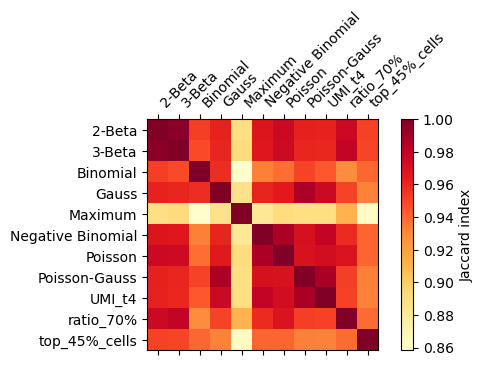

In [20]:
crispat.plot_intersection_heatmap(single_perturbations)

Additionally, there is a function called `plot_n_assigned_cells` which shows the total number of assigned cells (with 'X' markers, as well as the number of cells that got a single gRNA assigned (marked with a circle, only relevant for low MOI screens).

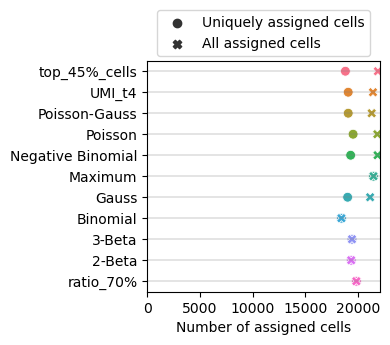

In [21]:
crispat.plot_n_assigned_cells(perturbations)